Copyright (c) MONAI Consortium  
Licensed under the Apache License, Version 2.0 (the "License");  
you may not use this file except in compliance with the License.  
You may obtain a copy of the License at  
&nbsp;&nbsp;&nbsp;&nbsp;http://www.apache.org/licenses/LICENSE-2.0  
Unless required by applicable law or agreed to in writing, software  
distributed under the License is distributed on an "AS IS" BASIS,  
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.  
See the License for the specific language governing permissions and  
limitations under the License.

# Benchmark TensorRT models inference

This tutorial shows how to convert a bundle in the MONAI model zoo to a TensorRT engine-based TorchScript for better performance and benchmark the difference between the PyTorch module and the TensorRT engine-based TorchScript.  
The `spleen_ct_segmentation` bundle is used as the example in this tutorial. The inference latency before and after the covert process will be compared. Feel free to modify the `spleen_ct_segmentation` bundle to other bundles in the MONAI model zoo which support TensorRT conversion. The TensorRT conversion is supported since **MONAI 1.2** with **Torch-TensorRT 1.4.0** and **TensorRT 8.5.3**. Please use the MONAI Docker whose version is greater than 1.2 or ensure the environment meets the min version requirement. The supported bundle names are listed below. Please modify the net_id and input_shape in the tutorial to fit different bundles.

```
spleen_ct_segmentation
endoscopic_tool_segmentation
endoscopic_inbody_classification
pathology_tumor_detection
```

The Spleen dataset can be downloaded from http://medicaldecathlon.com/.


## Setup environment

In [1]:
!python -c "import monai" || pip install -q "monai-weekly[nibabel, tqdm]"
!python -c "import matplotlib" || pip install -q matplotlib
%matplotlib inline

## Setup imports

In [2]:
import glob
import os
import tempfile

import torch
import numpy as np
from ignite.engine import Engine

import matplotlib.pyplot as plt
import monai
from monai.apps import download_and_extract
from monai.config import print_config
from monai.utils import optional_import
from ignite.engine import Events
from collections import OrderedDict
from monai.engines import IterationEvents

print_config()

MONAI version: 0.9.1+592.gd063dcf5.dirty
Numpy version: 1.22.2
Pytorch version: 1.14.0a0+44dac51
MONAI flags: HAS_EXT = True, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: d063dcf539f5befc91038bae7c847c43781a1811
MONAI __file__: /home/liubin/data/github_monai/export_trt_build/MONAI/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: 0.4.11
ITK version: 5.3.0
Nibabel version: 5.0.1
scikit-image version: 0.20.0
Pillow version: 9.2.0
Tensorboard version: 2.9.0
gdown version: 4.6.4
TorchVision version: 0.15.0a0
tqdm version: 4.64.1
lmdb version: 1.4.0
psutil version: 5.9.4
pandas version: 1.5.2
einops version: 0.6.0
transformers version: 4.21.3
mlflow version: 2.1.1
pynrrd version: 1.0.0

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



## Setup data directory

You can specify a directory with the `MONAI_DATA_DIRECTORY` environment variable.  
This allows you to save results and reuse downloads.  
If not specified a temporary directory will be used.

In [3]:
directory = os.environ.get("MONAI_DATA_DIRECTORY")
root_dir = tempfile.mkdtemp() if directory is None else directory
print(f"root dir is: {root_dir}")

root dir is: /workspace/data/medical


## Download dataset

Downloads and extracts the Decathlon Spleen dataset.

In [4]:
resource = "https://msd-for-monai.s3-us-west-2.amazonaws.com/Task09_Spleen.tar"
md5 = "410d4a301da4e5b2f6f86ec3ddba524e"

compressed_file = os.path.join(root_dir, "Task09_Spleen.tar")
data_root = os.path.join(root_dir, "Task09_Spleen")
if not os.path.exists(data_root):
    download_and_extract(resource, compressed_file, root_dir, md5)

## Download the spleen bundle

In [5]:
bundle_dir = "./"
bundle_path = os.path.join(bundle_dir, "spleen_ct_segmentation")
if not os.path.exists(bundle_path):
    monai.bundle.download(name="spleen_ct_segmentation", bundle_dir="./")

## Set MSD Spleen dataset path

In [6]:
train_images = sorted(glob.glob(os.path.join(data_root, "imagesTr", "*.nii.gz")))
train_labels = sorted(glob.glob(os.path.join(data_root, "labelsTr", "*.nii.gz")))
data_dicts = [{"image": image_name, "label": label_name} for image_name, label_name in zip(train_images, train_labels)]
train_files, val_files = data_dicts[:-9], data_dicts[-9:]

## Export the trt model with API

Export the downloaded bundle model to TensorRT engine-based TorchScript models. It takes a while for converting and will generate the `model_trt_fp32.ts` and `model_trt_fp16.ts` into the `model` folder.

The command is quite similar to the `ckpt_export` command, except the `precision` and `dynamic_batchsize` parameters. 

The `precision` parameter specifies the converted model weight precision which currently supports `fp32` and `fp16`. The `dynamic_batchsize` parameter is a sequence with three elements to define the batch size range of the input for the model to be converted. Should be a sequence like `[MIN_BATCH, OPT_BATCH, MAX_BATCH]`. After conversion, the batch size of model input should be between `MIN_BATCH` and `MAX_BATCH`. The `OPT_BATCH` is the best performance batch size that the TensorRT tries to fit. It should be the most frequently used input batch size in your application.

In [ ]:
%cd spleen_ct_segmentation
!python -m monai.bundle trt_export network_def --filepath models/model_trt_fp32.ts --ckpt_file models/model.pt --meta_file configs/metadata.json --config_file configs/inference.json --precision fp32 --dynamic_batchsize "[1, 4, 8]"
!python -m monai.bundle trt_export network_def --filepath models/model_trt_fp16.ts --ckpt_file models/model.pt --meta_file configs/metadata.json --config_file configs/inference.json --precision fp16 --dynamic_batchsize "[1, 4, 8]"
%cd ..

## Load the torch model and TensorRT model

Load the original torch model and the TensorRT engine-based TorchScript models. Please note that `torch_tensorrt` must be imported before loading TensorRT engine-based TorchScript models, since it will provide some runtime context.

In [8]:
def get_parser(meta_config, inference_config):
    parser = monai.bundle.ConfigParser()
    parser.read_meta(meta_config)
    parser.read_config(inference_config)
    return parser


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_weight = glob.glob(os.path.join("./spleen_ct_segmentation", "*", "model.pt"))[0]
meta_config = glob.glob(os.path.join("./spleen_ct_segmentation", "*", "metadata.*"))[0]
inference_config = glob.glob(os.path.join("./spleen_ct_segmentation", "*", "inference.*"))[0]
trt_fp32_model_path = os.path.join("./spleen_ct_segmentation", "models", "model_trt_fp32.ts")
trt_fp16_model_path = os.path.join("./spleen_ct_segmentation", "models", "model_trt_fp16.ts")

parser = get_parser(meta_config, inference_config)

# If using other bundles, the net_id and spatial_shape may change. Please modify these variables accordingly.
net_id = "network"
spatial_shape = (1, 1, 96, 96, 96)
model = parser.get_parsed_content(net_id)

model.eval()
model.to(device)
_, has_torchtrt = optional_import('torch_tensorrt', '1.4.0')
if has_torchtrt:
    trt_fp32_model = torch.jit.load(trt_fp32_model_path)
    trt_fp16_model = torch.jit.load(trt_fp16_model_path)

## Benchmark the model inference time

In this part, we benchmark the model inference with a random input, i.e. the model computation latency.

Total time for the torch model: 2526.1634764671326ms. Average time for the torch model: 5.052326952934255ms.


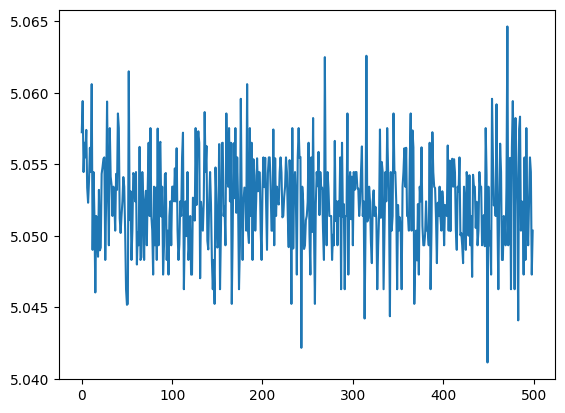

Total time for the TensorRT_fp32 model: 1073.8838262557983ms. Average time for the TensorRT_fp32 model: 2.1477676525115923ms.


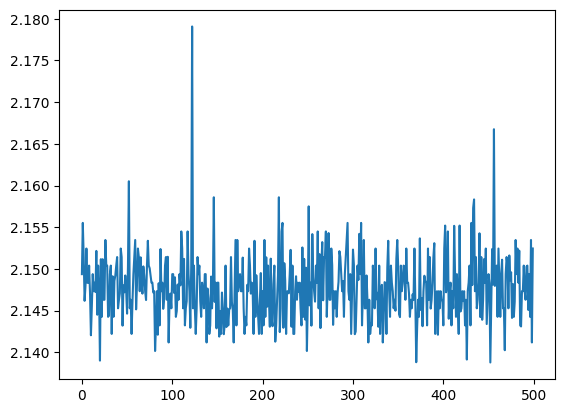

Total time for the TensorRT_fp16 model: 643.7912704944611ms. Average time for the TensorRT_fp16 model: 1.2875825409889194ms.


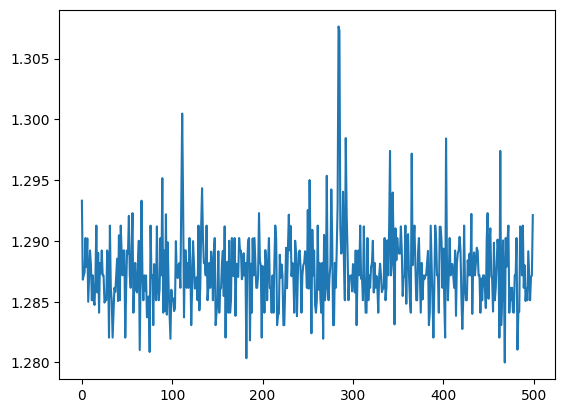

1.2875825409889194

In [9]:
def inference_random_torch_timer(model, input_shape, model_type="torch", warmup_iter=500, active_iter=500):
    """Do the inference several times and get the latency."""

    # Do some warmup in case there are extra libraries and models load overhead.
    with torch.no_grad():
        for _ in range(warmup_iter):
            random_input = torch.rand(input_shape, dtype=torch.float32, device=device)
            model(random_input)

        timeaccumulate = []
        for _ in range(active_iter):
            starter, ender = torch.cuda.Event(enable_timing=True), torch.cuda.Event(enable_timing=True)
            torch.cuda.synchronize()
            starter.record()
            model(random_input)
            ender.record()
            torch.cuda.synchronize()
            time_cur = starter.elapsed_time(ender)
            timeaccumulate.append(time_cur)
        total_time = sum(timeaccumulate)
        average_time = total_time / (len(timeaccumulate) + 1e-12)
    print(
        f"Total time for the {model_type} model: {total_time}ms.",
        f"Average time for the {model_type} model: {average_time}ms."
    )
    plt.plot(timeaccumulate)
    plt.show(model_type)
    return average_time


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Only test the fp32 precision torch model
torch.backends.cuda.matmul.allow_tf32 = False
torch.backends.cudnn.allow_tf32 = False

inference_random_torch_timer(model, spatial_shape, model_type="torch")
inference_random_torch_timer(trt_fp32_model, spatial_shape, model_type="TensorRT_fp32")
inference_random_torch_timer(trt_fp16_model, spatial_shape, model_type="TensorRT_fp16")

## Benchmark the end to end bundle run

In this part, the `evaluator` in the `spleen_ct_segmentation` is parsed to do the end to end inference. A `TimerHandler` is defined to benchmark every part of the inference process.

### Define the TimerHandler

Define a `CUDATimer` to time the latency on GPU and a `TimerHandler` to attach this timer to every part of end2end inference.

In [10]:
class CUDATimer:
    def __init__(self, type_str) -> None:
        self.time_list = []
        self.type_str = type_str

    def start(self) -> None:
        self.starter = torch.cuda.Event(enable_timing=True)
        self.ender = torch.cuda.Event(enable_timing=True)
        torch.cuda.synchronize()
        self.starter.record()

    def end(self) -> None:
        self.ender.record()
        torch.cuda.synchronize()
        self.time_list.append(self.starter.elapsed_time(self.ender))

    def get_max(self) -> float:
        return max(self.time_list)

    def get_min(self) -> float:
        return min(self.time_list)

    def get_mean(self) -> float:
        np_time = np.array(self.time_list)
        return np.mean(np_time)

    def get_std(self) -> float:
        np_time = np.array(self.time_list)
        return np.std(np_time)

    def get_sum(self) -> float:
        np_time = np.array(self.time_list)
        return np.sum(np_time)

    def get_results_dict(self) -> OrderedDict:
        out_list = [
            ("total", self.get_sum()),
            ("min", self.get_min()),
            ("max", self.get_max()),
            ("mean", self.get_mean()),
            ("std", self.get_std()),
        ]
        return OrderedDict(out_list)


class TimerHandler:
    def __init__(self) -> None:
        self.run_timer = CUDATimer("RUN")
        self.epoch_timer = CUDATimer("EPOCH")
        self.iteration_timer = CUDATimer("ITERATION")
        self.net_forward_timer = CUDATimer("FORWARD")
        self.get_batch_timer = CUDATimer("PREPARE_BATCH")
        self.post_process_timer = CUDATimer("POST_PROCESS")
        self.timer_list = [
            self.run_timer,
            self.epoch_timer,
            self.iteration_timer,
            self.net_forward_timer,
            self.get_batch_timer,
            self.post_process_timer,
        ]

    def attach(self, engine: Engine) -> None:
        engine.add_event_handler(Events.STARTED, self.started, timer=self.run_timer)
        engine.add_event_handler(Events.EPOCH_STARTED, self.started, timer=self.epoch_timer)
        engine.add_event_handler(Events.ITERATION_STARTED, self.started, timer=self.iteration_timer)
        engine.add_event_handler(Events.GET_BATCH_STARTED, self.started, timer=self.get_batch_timer)
        engine.add_event_handler(Events.GET_BATCH_COMPLETED, self.completed, timer=self.get_batch_timer)
        engine.add_event_handler(Events.GET_BATCH_COMPLETED, self.started, timer=self.net_forward_timer)
        engine.add_event_handler(IterationEvents.FORWARD_COMPLETED, self.completed, timer=self.net_forward_timer)
        engine.add_event_handler(IterationEvents.FORWARD_COMPLETED, self.started, timer=self.post_process_timer)
        engine.add_event_handler(Events.ITERATION_COMPLETED, self.completed, timer=self.post_process_timer)
        engine.add_event_handler(Events.ITERATION_COMPLETED, self.completed, timer=self.iteration_timer)
        engine.add_event_handler(Events.EPOCH_COMPLETED, self.completed, timer=self.epoch_timer)
        engine.add_event_handler(Events.COMPLETED, self.completed, timer=self.run_timer)

    def started(self, engine: Engine, timer: CUDATimer) -> None:
        timer.start()

    def completed(self, engine: Engine, timer: CUDATimer) -> None:
        timer.end()

    def print_results(self) -> None:
        def dict_to_str(results_dict) -> str:
            return "|".join(f"{v:.5f}" for v in results_dict.values())

        out_title = """
 -----------------------------------------------------------
| Time profiling stats (in ms):                             |
 -----------------------------------------------------------
|   total   |    min    |    max    |    mean    |    std   |
        """
        print(out_title)
        for timer in self.timer_list:
            print(f"{timer.type_str}:")
            print(dict_to_str(timer.get_results_dict()))

### Benchmark the pytorch model

In this part, an `evaluator` with the original pytorch model runs several iterations to benchmark the latency.

In [ ]:
torch_parser = get_parser(meta_config, inference_config)
torch_parser["dataset_dir"] = data_root
torch_parser["bundle_root"] = "./spleen_ct_segmentation"
torch_evaluator = torch_parser.get_parsed_content("evaluator")
torch_timer = TimerHandler()
torch_timer.attach(torch_evaluator)
torch_evaluator.run()

In [12]:
torch_timer.print_results()


 -----------------------------------------------------------
| Time profiling stats (in ms):                             |
 -----------------------------------------------------------
|   total   |    min    |    max    |    mean    |    std   |
        
RUN:
15222.24707|15222.24707|15222.24707|15222.24707|0.00000
EPOCH:
15221.52148|15221.52148|15221.52148|15221.52148|0.00000
ITERATION:
13485.55690|208.89037|1536.05127|674.27785|323.68567
FORWARD:
3222.78642|47.25904|431.67065|161.13932|95.44593
PREPARE_BATCH:
1527.81833|0.09370|786.40533|76.39092|204.24058
POST_PROCESS:
10261.28465|161.58061|1433.63159|513.06423|285.14471


### Benchmark the TensorRT fp32 and fp16 models

Update the config parser with Torch-TensorRT models and benchmark the end to end latency. Since the `POST_PROCESS` and `PREPARE_BATCH` part takes a lot of time, the acceleration of model computation doesn't have much effect on the end2end latency.

In [ ]:
# replace the model load part and remove the CheckpointLoader handler
def del_ckpt_loader(parser):
    ckpt_index = -1
    for cnt, handler in enumerate(parser["handlers"]):
        if handler["_target_"] == "CheckpointLoader":
            ckpt_index = cnt
    if ckpt_index != -1:
        del parser["handlers"][ckpt_index]


trt32_parser = get_parser(meta_config, inference_config)
trt32_parser["dataset_dir"] = data_root
trt32_parser["bundle_root"] = "./spleen_ct_segmentation"

# Use torch.jit.load to load the jit model
trt32_parser[net_id] = f"$torch.jit.load('{trt_fp32_model_path}')"
del_ckpt_loader(trt32_parser)
trt32_evaluator = torch_parser.get_parsed_content("evaluator")
trt32_timer = TimerHandler()
trt32_timer.attach(torch_evaluator)
trt32_evaluator.run()

In [14]:
trt32_timer.print_results()


 -----------------------------------------------------------
| Time profiling stats (in ms):                             |
 -----------------------------------------------------------
|   total   |    min    |    max    |    mean    |    std   |
        
RUN:
15238.21777|15238.21777|15238.21777|15238.21777|0.00000
EPOCH:
15237.48242|15237.48242|15237.48242|15237.48242|0.00000
ITERATION:
12869.57535|208.57166|1503.17871|643.47877|333.88372
FORWARD:
3111.75409|31.91382|431.12921|155.58770|100.28316
PREPARE_BATCH:
2136.63352|0.12819|1461.07605|106.83168|329.95567
POST_PROCESS:
9757.88312|160.94887|1404.77625|487.89416|287.22577


In [ ]:
trt16_parser = get_parser(meta_config, inference_config)
trt16_parser["dataset_dir"] = data_root
trt16_parser["bundle_root"] = "./spleen_ct_segmentation"

# Use torch.jit.load to load the jit model
trt16_parser[net_id] = f"$torch.jit.load('{trt_fp16_model_path}')"
del_ckpt_loader(trt32_parser)
trt16_evaluator = torch_parser.get_parsed_content("evaluator")
trt16_timer = TimerHandler()
trt16_timer.attach(torch_evaluator)
trt16_evaluator.run()

In [16]:
trt16_timer.print_results()


 -----------------------------------------------------------
| Time profiling stats (in ms):                             |
 -----------------------------------------------------------
|   total   |    min    |    max    |    mean    |    std   |
        
RUN:
15308.54980|15308.54980|15308.54980|15308.54980|0.00000
EPOCH:
15307.96094|15307.96094|15307.96094|15307.96094|0.00000
ITERATION:
13049.93951|210.64490|1512.33618|652.49698|334.00644
FORWARD:
3107.91713|31.94451|431.99619|155.39586|100.47197
PREPARE_BATCH:
2021.56238|0.15818|1325.01648|101.07812|303.22942
POST_PROCESS:
9942.34689|162.37312|1415.01160|497.11734|289.32993
